# K-Means vs Agglomerative Hierarchical Clustering Comparative Analysis

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ------------------------------ Diabetes Dataset ------------------------------------
# K-Means Clustering
## Load and Prepare Dataset

In [50]:
diabetes_df = pd.read_csv("diabetes_prediction_dataset.csv")

diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [51]:
# drop 'diabetes' column
new_diabetes_df = diabetes_df.drop(columns=['diabetes'])

# check new dataframe shape and columns
print("Original shape:", diabetes_df.shape)
print("After dropping 'diabetes' column:", new_diabetes_df.shape)

new_diabetes_df.head()

Original shape: (100000, 9)
After dropping 'diabetes' column: (100000, 8)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Female,80.0,0,1,never,25.19,6.6,140
1,Female,54.0,0,0,No Info,27.32,6.6,80
2,Male,28.0,0,0,never,27.32,5.7,158
3,Female,36.0,0,0,current,23.45,5.0,155
4,Male,76.0,1,1,current,20.14,4.8,155


In [52]:
# identify null values
new_diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 6.1+ MB


In [53]:
# list out categorical and numerical columns
categorical_cols = new_diabetes_df.select_dtypes(include=["object","category"]).columns.tolist()
numerical_cols = new_diabetes_df.select_dtypes(include=["number"]).columns.tolist()

print("Categorical columns:")
print(categorical_cols)

print("\nNumerical columns:")
print(numerical_cols)

Categorical columns:
['gender', 'smoking_history']

Numerical columns:
['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']


## Encode Categorical Columns

In [54]:
print("Unique values in gender:", new_diabetes_df['gender'].unique())
print("Unique values in smoking_history:", new_diabetes_df['smoking_history'].unique())

Unique values in gender: ['Female' 'Male' 'Other']
Unique values in smoking_history: ['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [55]:
# encode categorical variables using One-Hot Encoding
encoded_diabetes_df = pd.get_dummies(new_diabetes_df, columns=['gender', 'smoking_history'], drop_first=True)

print("Shape after encoding:", encoded_diabetes_df.shape)
encoded_diabetes_df.head()

Shape after encoding: (100000, 13)


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,1,0,1,0,0,0,0


In [56]:
unscaled_diabetes_df = encoded_diabetes_df.copy()

In [57]:
# scale the data
scaler = StandardScaler()
scaled_diabetes_df = scaler.fit_transform(unscaled_diabetes_df)

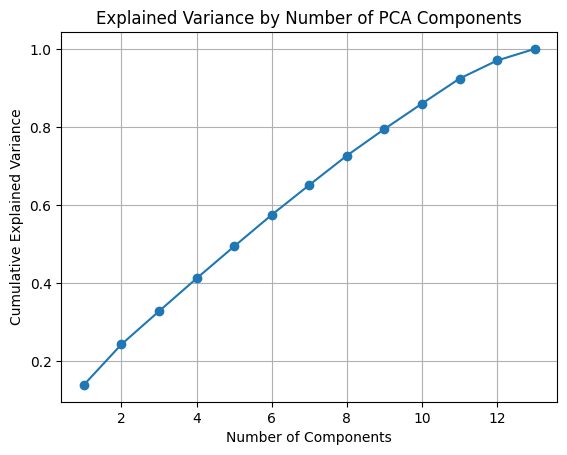

In [58]:
# check for number of PCA components
pca = PCA().fit(scaled_diabetes_df)
explained = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCA Components')
plt.grid(True)
plt.show()

## Normalised K-Means (Cosine Distance) PCA BEFORE clustering

In [59]:
# scale then normalise
scaled_diabetes_df = scaler.fit_transform(unscaled_diabetes_df)
scaled_normalized_diabetes_df = normalize(scaled_diabetes_df)

# PCA before clustering
pca_scaled_norm_before = PCA(n_components=3, random_state=42)
scaled_norm_df_pca_before = pca_scaled_norm_before.fit_transform(scaled_normalized_diabetes_df)

# silhouette score
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_norm_df_pca_before)
    score = silhouette_score(scaled_norm_df_pca_before, labels, metric='cosine')
    silhouette_scores.append(score)
    
# choose best k from silhouette
best_k_sil = K[silhouette_scores.index(max(silhouette_scores))]

# run final K-Means with best k
kmeans_scaled_cos_pca_before = KMeans(n_clusters=best_k_sil, random_state=42, n_init=10)
labels_scaled_cos_pca_before = kmeans_scaled_cos_pca_before.fit_predict(scaled_norm_df_pca_before)

# Agglomerative Hierarchical Clustering (AHC)
## Preprocessing of Dataset

In [60]:
# Load dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [61]:
# Understanding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [62]:
# Checking for empty rows
empty_rows = df.isnull().all(axis=1)
print(f"Empty rows: {empty_rows}")

Empty rows: 0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool


In [63]:
# Drop diabetes column
X = df.drop("diabetes", axis=1)
X

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Female,80.0,0,1,never,25.19,6.6,140
1,Female,54.0,0,0,No Info,27.32,6.6,80
2,Male,28.0,0,0,never,27.32,5.7,158
3,Female,36.0,0,0,current,23.45,5.0,155
4,Male,76.0,1,1,current,20.14,4.8,155
...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90
99996,Female,2.0,0,0,No Info,17.37,6.5,100
99997,Male,66.0,0,0,former,27.83,5.7,155
99998,Female,24.0,0,0,never,35.42,4.0,100


In [64]:
# Standardizing input features
num_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
bin_features = ["hypertension", "heart_disease"]
cat_features = ["gender", "smoking_history"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("bin", "passthrough", bin_features), 
    ("cat", OneHotEncoder(), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X)
print(X_preprocessed)

[[ 1.69270354e+00 -3.21055792e-01  1.00170572e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 5.38006427e-01 -1.15583678e-04  1.00170572e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.16690686e-01 -1.15583678e-04  1.61108022e-01 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 ...
 [ 1.07094356e+00  7.67292549e-02  1.61108022e-01 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.94336396e-01  1.22036126e+00 -1.42668764e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 6.71240710e-01 -7.36921977e-01  1.00170572e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


## Training 
## Sampling Dataset

In [65]:
sample_size = 10000

np.random.seed(42)
sample_idx = np.random.choice(len(X_preprocessed), size=sample_size, replace=False)

X_sample = X_preprocessed[sample_idx]
X_sample

array([[-1.2828621 , -0.97951058,  0.25450777, ...,  0.        ,
         0.        ,  0.        ],
       [-1.72697637, -0.95238888, -0.49269019, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93770927, -0.30146789, -1.89368636, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.37168495, -0.66761095, -1.89368636, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.89329785, -0.71432055,  0.16110802, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.22712644, -0.59227287, -0.95968891, ...,  1.        ,
         0.        ,  0.        ]])

## Determining the optimal number of clusters
- Silhouette scores  
- Davies-Bouldin index 
- Calinski-Harabasz index

In [66]:
candidate_clusters = range(2, 50)
sil_list_clusters = []
dbi_list_clusters = []
chi_list_clusters = []

for n in candidate_clusters:
    ahc_clusters = AgglomerativeClustering(n_clusters=n, linkage="ward")
    labels_clusters = ahc_clusters.fit_predict(X_sample)

    sil_clusters = silhouette_score(X_sample, labels_clusters)
    dbi_clusters = davies_bouldin_score(X_sample, labels_clusters)
    chi_clusters = calinski_harabasz_score(X_sample, labels_clusters)

    sil_list_clusters.append(sil_clusters)
    dbi_list_clusters.append(dbi_clusters)
    chi_list_clusters.append(chi_clusters)

    print(f"Number of clusters: {n}, Silhouette score: {sil_clusters:.3f}, Davies-Bouldin score: {dbi_clusters:.3f}, Calinski-Harabasz score: {chi_clusters:.3f}")

max_sil_clusters = max(sil_list_clusters)
min_dbi_clusters = min(dbi_list_clusters)
max_chi_clusters = max(chi_list_clusters)

optimal_clusters_sil = candidate_clusters[sil_list_clusters.index(max_sil_clusters)]
optimal_clusters_dbi = candidate_clusters[dbi_list_clusters.index(min_dbi_clusters)]
optimal_clusters_chi = candidate_clusters[chi_list_clusters.index(max_chi_clusters)]

print()
print(f"Highest Silhouette score: {max_sil_clusters:.3f}, Optimal number of clusters: {optimal_clusters_sil}")
print(f"Lowest Davies-Bouldin score: {min_dbi_clusters:.3f}, Optimal number of clusters: {optimal_clusters_dbi}")
print(f"Highest Calinski-Harbasz score: {max_chi_clusters:.3f}, Optimal number of clusters: {optimal_clusters_chi}")

Number of clusters: 2, Silhouette score: 0.117, Davies-Bouldin score: 2.515, Calinski-Harabasz score: 1441.207
Number of clusters: 3, Silhouette score: 0.098, Davies-Bouldin score: 2.044, Calinski-Harabasz score: 1330.149
Number of clusters: 4, Silhouette score: 0.113, Davies-Bouldin score: 1.882, Calinski-Harabasz score: 1313.676
Number of clusters: 5, Silhouette score: 0.120, Davies-Bouldin score: 1.799, Calinski-Harabasz score: 1316.665
Number of clusters: 6, Silhouette score: 0.110, Davies-Bouldin score: 1.893, Calinski-Harabasz score: 1246.285
Number of clusters: 7, Silhouette score: 0.107, Davies-Bouldin score: 1.976, Calinski-Harabasz score: 1198.297
Number of clusters: 8, Silhouette score: 0.102, Davies-Bouldin score: 2.021, Calinski-Harabasz score: 1112.104
Number of clusters: 9, Silhouette score: 0.085, Davies-Bouldin score: 2.048, Calinski-Harabasz score: 1041.932
Number of clusters: 10, Silhouette score: 0.081, Davies-Bouldin score: 2.021, Calinski-Harabasz score: 990.985
N

# K-Means vs AHC Metrics Comparison

In [67]:
ahc_final = AgglomerativeClustering(n_clusters=optimal_clusters_sil, linkage="ward")
labels_ahc_final = ahc_final.fit_predict(X_sample)

# compute evaluation metrics
results = {
    "Method": ["K-Means (Cosine, PCA Before)", "AHC (Ward)"],
    "Silhouette Score": [
        silhouette_score(scaled_norm_df_pca_before, labels_scaled_cos_pca_before, metric='cosine'),
        silhouette_score(X_sample, labels_ahc_final)
    ],
    "Davies-Bouldin Index": [
        davies_bouldin_score(scaled_norm_df_pca_before, labels_scaled_cos_pca_before),
        davies_bouldin_score(X_sample, labels_ahc_final)
    ],
    "Calinski-Harabasz Score": [
        calinski_harabasz_score(scaled_norm_df_pca_before, labels_scaled_cos_pca_before),
        calinski_harabasz_score(X_sample, labels_ahc_final)
    ]
}

df_results = pd.DataFrame(results)
df_results = df_results.round(4)
print(df_results)

                         Method  Silhouette Score  Davies-Bouldin Index  \
0  K-Means (Cosine, PCA Before)            0.7065                0.6838   
1                    AHC (Ward)            0.1325                1.7568   

   Calinski-Harabasz Score  
0               95770.1166  
1                 480.0601  


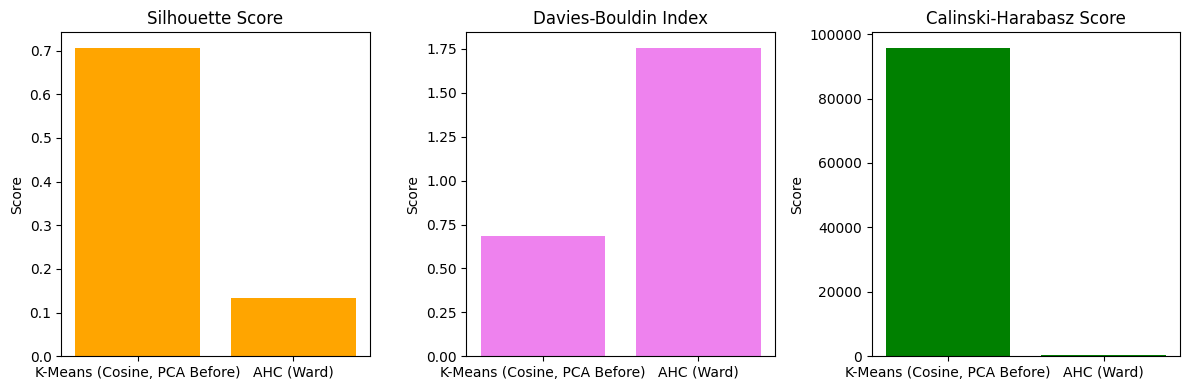

In [68]:
# bar chart to compare metrics 
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
metrics = ["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Score"]
colors = ['orange', 'violet', 'green']

for i, metric in enumerate(metrics):
    axes[i].bar(df_results["Method"], df_results[metric], color=colors[i])
    axes[i].set_title(metric)
    if metric == "Davies-Bouldin Index":
        axes[i].set_ylabel("Score")
    else:
        axes[i].set_ylabel("Score")

plt.tight_layout()
plt.show()

# ------------------------------ Body Fat Dataset ------------------------------------
# K-Means Clustering
## Load and Prepare Dataset

In [69]:
body_df = pd.read_csv("bodyfat.csv")

body_df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [70]:
# drop 'BodyFat' column
new_body_df = body_df.drop(columns=['BodyFat'])

# check new dataframe shape and columns
print("Original shape:", body_df.shape)
print("After dropping 'BodyFat' column:", new_body_df.shape)

new_body_df.head()

Original shape: (252, 15)
After dropping 'BodyFat' column: (252, 14)


,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [71]:
# identify null values
new_body_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


In [72]:
# list out categorical and numerical columns
categorical_cols = new_body_df.select_dtypes(include=["object","category"]).columns.tolist()
numerical_cols = new_body_df.select_dtypes(include=["number"]).columns.tolist()

print("Categorical columns:")
print(categorical_cols)

print("\nNumerical columns:")
print(numerical_cols)

Categorical columns:
[]

Numerical columns:
['Density', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']


In [73]:
# scale the data
scaler = StandardScaler()
scaled_body_df = scaler.fit_transform(new_body_df)

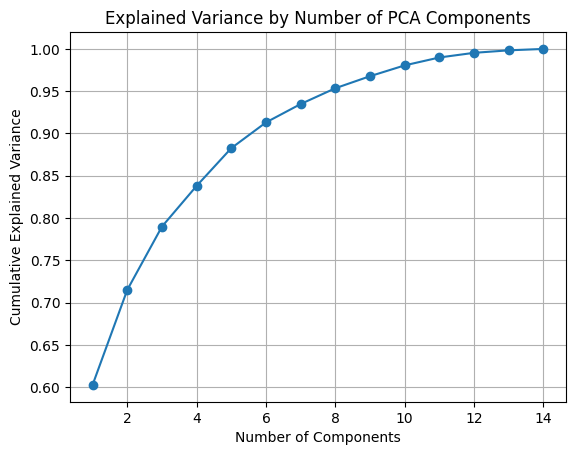

In [74]:
# check for number of PCA components
pca = PCA().fit(scaled_body_df)
explained = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCA Components')
plt.grid(True)
plt.show()

## Normalised K-Means (Cosine Distance) PCA BEFORE clustering

In [75]:
# scale then normalise
scaled_body_df = scaler.fit_transform(new_body_df)
scaled_normalized_body_df = normalize(scaled_body_df)

# PCA before clustering
pca_scaled_norm_before = PCA(n_components=3, random_state=42)
scaled_norm_body_df_pca_before = pca_scaled_norm_before.fit_transform(scaled_normalized_body_df)

# silhouette score
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_norm_body_df_pca_before)
    score = silhouette_score(scaled_norm_body_df_pca_before, labels, metric='cosine')
    silhouette_scores.append(score)
    
# choose best k from silhouette
best_k_sil = K[silhouette_scores.index(max(silhouette_scores))]

# run final K-Means with best k
kmeans_scaled_cos_pca_before = KMeans(n_clusters=best_k_sil, random_state=42, n_init=10)
labels_scaled_cos_pca_before = kmeans_scaled_cos_pca_before.fit_predict(scaled_norm_body_df_pca_before)

# Agglomerative Hierarchical Clustering (AHC)
## Preprocessing of Dataset

In [76]:
df = pd.read_csv("bodyfat.csv")
df

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,11.0,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,1.0236,33.6,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,1.0328,29.3,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,1.0399,26.0,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


In [77]:
# Understanding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB


In [78]:
# Checking for empty rows
empty_rows = df.isnull().all(axis=1)
print(f"Empty rows: {empty_rows}")

Empty rows: 0      False
1      False
2      False
3      False
4      False
       ...  
247    False
248    False
249    False
250    False
251    False
Length: 252, dtype: bool


In [79]:
# Drop BodyFat column
X = df.drop(columns=["BodyFat"])
X

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


In [80]:
# Standardizing input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[ 0.80164696 -1.74007329 -0.84124583 ... -0.09067593 -0.62671828
  -1.2125412 ]
 [ 1.56506057 -1.81958344 -0.19346239 ... -0.58814329  0.11707924
  -0.0319426 ]
 [-0.74623993 -1.81958344 -0.84976929 ... -1.15193963 -1.71762131
  -1.74917692]
 ...
 [-1.19902317  2.15592399  0.26680479 ... -0.32282736 -0.72589128
  -0.24659689]
 [-0.82521375  2.15592399  0.40318025 ... -0.58814329  0.36501175
   1.68529172]
 [-1.49912369  2.31494429  0.97425249 ...  0.47312041  0.66253075
   2.86589032]]


## Determining the optimal number of clusters
- Silhouette scores  
- Davies-Bouldin index 
- Calinski-Harabasz index

In [81]:
candidate_clusters = range(2, 50)
sil_score_list = []
dbi_score_list = []
chi_score_list = []

for n_clusters in candidate_clusters:
    ahc_clusters = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels_clusters = ahc_clusters.fit_predict(X_scaled)

    sil_score = silhouette_score(X_scaled, labels_clusters)
    dbi_score = davies_bouldin_score(X_scaled, labels_clusters)
    chi_score = calinski_harabasz_score(X_scaled, labels_clusters)

    sil_score_list.append(sil_score)
    dbi_score_list.append(dbi_score)
    chi_score_list.append(chi_score)

    print(f"Number of clusters: {n_clusters}, Silhouette score: {sil_score:.3f}, Davies-Bouldin score: {dbi_score:.3f}, Calinski-Harabasz score: {chi_score:.3f}")

max_sil = max(sil_score_list)
min_dbi = min(dbi_score_list)
max_chi = max(chi_score_list)

optimal_clusters_sil = candidate_clusters[sil_score_list.index(max_sil)]
optimal_clusters_dbi = candidate_clusters[dbi_score_list.index(min_dbi)]
optimal_clusters_chi = candidate_clusters[chi_score_list.index(max_chi)]

print()
print(f"Highest silhouette score: {max_sil:.3f}, Optimal number of clusters: {optimal_clusters_sil}")
print(f"Lowest Davies-Bouldin score: {min_dbi:.3f}, Optimal number of clusters: {optimal_clusters_dbi}")
print(f"Highest Calinski-Harabasz: {max_chi:.3f}, Optimal number of clusters: {optimal_clusters_chi}")

Number of clusters: 2, Silhouette score: 0.326, Davies-Bouldin score: 1.158, Calinski-Harabasz score: 150.019
Number of clusters: 3, Silhouette score: 0.190, Davies-Bouldin score: 1.489, Calinski-Harabasz score: 102.226
Number of clusters: 4, Silhouette score: 0.166, Davies-Bouldin score: 1.664, Calinski-Harabasz score: 84.968
Number of clusters: 5, Silhouette score: 0.166, Davies-Bouldin score: 1.400, Calinski-Harabasz score: 74.462
Number of clusters: 6, Silhouette score: 0.168, Davies-Bouldin score: 1.187, Calinski-Harabasz score: 69.449
Number of clusters: 7, Silhouette score: 0.152, Davies-Bouldin score: 1.306, Calinski-Harabasz score: 63.979
Number of clusters: 8, Silhouette score: 0.152, Davies-Bouldin score: 1.292, Calinski-Harabasz score: 60.234
Number of clusters: 9, Silhouette score: 0.136, Davies-Bouldin score: 1.183, Calinski-Harabasz score: 57.316
Number of clusters: 10, Silhouette score: 0.137, Davies-Bouldin score: 1.279, Calinski-Harabasz score: 55.105
Number of cluste

# K-Means vs AHC Metrics Comparison

In [82]:
ahc_final = AgglomerativeClustering(n_clusters=optimal_clusters_sil, linkage="ward")
labels_ahc_final = ahc_final.fit_predict(X_scaled)

# compute evaluation metrics
results = {
    "Method": ["K-Means (Cosine, PCA Before)", "AHC (Ward)"],
    "Silhouette Score": [
        silhouette_score(scaled_norm_body_df_pca_before, labels_scaled_cos_pca_before, metric='cosine'),
        silhouette_score(X_scaled, labels_ahc_final)
    ],
    "Davies-Bouldin Index": [
        davies_bouldin_score(scaled_norm_body_df_pca_before, labels_scaled_cos_pca_before),
        davies_bouldin_score(X_scaled, labels_ahc_final)
    ],
    "Calinski-Harabasz Score": [
        calinski_harabasz_score(scaled_norm_body_df_pca_before, labels_scaled_cos_pca_before),
        calinski_harabasz_score(X_scaled, labels_ahc_final)
    ]
}

df_results = pd.DataFrame(results)
df_results = df_results.round(4)
print(df_results)

                         Method  Silhouette Score  Davies-Bouldin Index  \
0  K-Means (Cosine, PCA Before)            0.6627                0.8549   
1                    AHC (Ward)            0.3258                1.1585   

   Calinski-Harabasz Score  
0                 290.5301  
1                 150.0195  


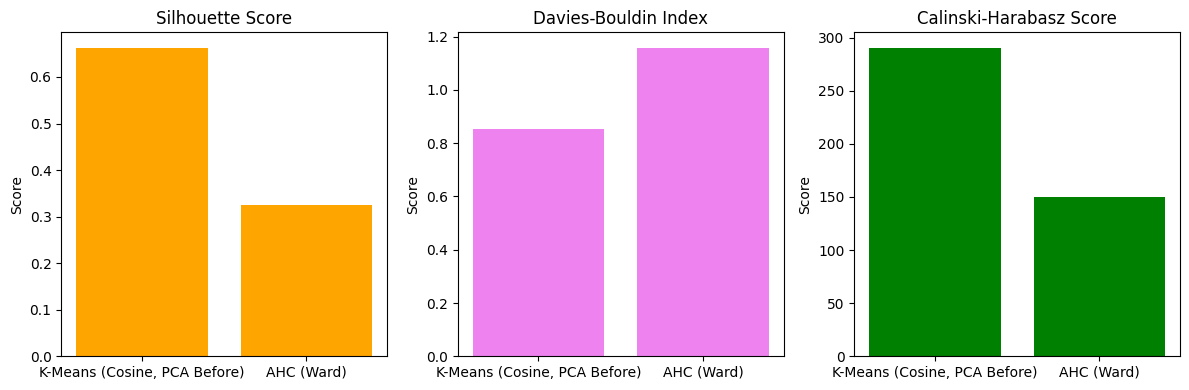

In [83]:
# bar chart to compare metrics 
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
metrics = ["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Score"]
colors = ['orange', 'violet', 'green']

for i, metric in enumerate(metrics):
    axes[i].bar(df_results["Method"], df_results[metric], color=colors[i])
    axes[i].set_title(metric)
    if metric == "Davies-Bouldin Index":
        axes[i].set_ylabel("Score")
    else:
        axes[i].set_ylabel("Score")

plt.tight_layout()
plt.show()